# 基于随机森林和梯度提升树的乳腺癌检测与分析

目录

1. [项目概述](#1项目概述)  
2. [数据预处理与探索性分析](#2数据预处理与探索性分析)  
   2.1 [数据集概述](#21数据集概述)  
   2.2 [数据可视化](#22数据可视化)
      - [箱线图](#箱线图)
      - [饼图](#饼图)
      - [成对分析图](#成对分析图)
      - [热力图](#热力图)

3. [特征工程](#3特征工程)  
   3.1 [特征缩放](#31特征缩放)  
      - [独热编码](#独热编码)
      - [RobustScaler缩放](#RobustScaler缩放)
   
   3.2 [降维](#32降维)  
      - [主成分分析(pca)](#主成分分析pca)
      - [递归特征消除与交叉验证（REFCV）](#递归特征消除与交叉验证refcv)

   3.3 [超参数选择网格搜索交叉验证](#33超参数选择网格搜索交叉验证)    
4. [模型性能指标](#4模型性能指标)  
   - [随机森林中PCA主成分数量与模型准确率训练时间的关系](#随机森林中pca主成分数量与模型准确率训练时间的关系)
   - [混淆矩阵及其性能指标](#混淆矩阵及其性能指标)
   - [ROC曲线(AUC)](#roc曲线auc)
   - [精确率-召回率曲线](#精确率-召回率曲线)

5. [模型训练](#5模型训练)  
   5.1 [梯度提升树与主成分分析法(PCA)](#51梯度提升树与主成分分析法pca)

   5.2 [随机森林与主成分分析法(PCA)](#52随机森林与主成分分析法pca)

   5.3 [梯度提升树与递归特征消除(REF)](#53梯度提升树与递归特征消除ref)

   5.4 [随机森林与递归特征消除(REF)](#54随机森林与递归特征消除rfe)
   
6. [模型综合比较与建议](#6模型综合比较与建议)  

## 1、项目概述

**项目目标**

1. **数据预处理**：对数据进行清洗、特征缩放、降维操作，为模型训练做好准备。
2. **模型训练**：使用随机森林和梯度提升树对数据进行分类。
3. **模型优化**：通过超参数调优（网格搜索交叉验证）和特征选择（PCA、RFE）提升模型性能。
4. **模型评估**：通过混淆矩阵及其他性能指标、ROC曲线、精确率-召回率曲线，**PCA主成分数与时间关系**指标评估模型的分类效果。
5. **模型比较**：对比不同模型及其优化方法的性能，得出最佳方案。

**数据集**

数据集来自Kaggle

链接：https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data/data

**主要方法**

1. 数据探索与可视化：通过箱线图、饼图、成对关系图、热力图等方法分析数据分布和特征间的相关性。
2. 特征工程：采用特征缩放、主成分分析（PCA）、递归特征消除（RFE）技术优化特征。
3. 模型训练与优化：使用随机森林、梯度提升树模型，并结合PCA和RFE进行优化。
4. 模型评估与比较：通过准确率、灵敏度、特异性、精确率、F1分数、等指标评估模型性能。

**创新点**

将**PCA主成分数与时间关系**作为模型性能评估的一种指标

*信安23-1程慧*

导入必要的Python库

In [33]:
import numpy as np 
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve, auc
from plotly.subplots import make_subplots
import itertools
# Run the following two lines of code for Uncaught Error: Script error for plotly
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

## 2、数据预处理与探索性分析

### 2.1、数据集概述

读取数据集文件，并展示其前几行内容，以便我们对数据集有一个初步的了解。

In [34]:
df = pd.read_csv('BCD_data.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


检查数据集中是否存在**缺失值**，并统计每一列中缺失值的数量。

In [35]:
missing_values_count = df.isnull().sum()
missing_values_count

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

**初步观察得到数据类别：**
1. id
2. diagnosis（M = 恶性，B = 良性
3. radius
4. texture
5. perimeter
6. area
7. smoothness
8. compactness
9. concavity
10. concave points
11. symmetry
12. fractal_dimension

- 除了id和diagnosis，剩余10个特征都计算了均值（mean）、标准差（se）和最差值（worst），共32个特征。

- 除了id和diagnosis，其余特征值保留四位有效数字。

- 32个特征无缺失值。

- 类别分布：357个良性，212个恶性。

**！**

*可以发现有一列很奇怪，打印得到列名为Unnamed:32，其值全为NaN*

*通过检查数据集发现，第33列（32是从0编号得到的）是空列，这列是不需要的，后续可以删除*

In [36]:
df.drop(['id','Unnamed: 32'],axis=1,inplace=True)

**有四点需要注意：**
1) **id** 不能用于分类
2) **Diagnosis** 是我们的标签
3) **Unnamed: 32** 特征包含NaN，可以删除
4) 其他特征名其实不用太关心，因为机器学习会自动处理

因此，先删除这些无用特征。

### 2.2、数据可视化

初步处理后，我们剩下了31个特征

In [37]:
df.shape

(569, 31)

现在我们有了特征，但这些特征代表什么？
我们可以先了解方差、标准差、样本数、最大最小值等统计信息，进一步理解数据。

可以发现，**area_mean** 最大值为2500，而 **smoothness_mean** 最大值只有0.16340。我们需要进一步进行特征缩放

还需要别的处理吗？这些特征间有什么关系呢？别着急，我们先进行**数据可视化**

In [38]:
df.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


#### 箱线图

**箱线图**是一种统计图表，用于显示数据分布的集中趋势、离散程度以及异常值。

- 首先看箱体： 下边线代表**下四分位数（第一四分位数，Q1）**，表示整体数据中有25%的数据少于该值
- 上边线代表**上四分位数（第三四分位数，Q3）**，表示整体数据中有75%的数据少于该值
- 箱体中间的线代表**中位数**，是一组数从小到大排列，居于正中间的单个数或正中间两个数的均值
- 箱体的长度代表第三四分位数和第一四分位数的差值，也称为**四分位间距（interquartile range，IQR）**
- 箱体两端的衍生线最左延伸至**Q1 - 1.5 x IQR（下极限）**，最右延伸至 **Q3 + 1.5 x IQR（上极限）**
- 超出上下极限线的点（或其他标记）表示**潜在异常值（outliers）**。

**好处**：

箱线图能够直观地展示数据的分布情况，包括中位数（Median）、四分位数（Quartiles）和范围（Range），并通过绘制“须”（Whiskers）和“异常点”来突出显示数据中的异常值，便于进一步分析和处理。

由于特征值较多，我们以10个特征为一组，分三组展示

In [39]:
names = df.columns[1:10]
values=[] 
for column in df.iloc[:,1:10].columns:
    li = df[column].tolist()
    values.append(li)
colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen','cyan', 'royalblue']

fig = go.Figure()
for xd, yd, cls in zip(names, values, colors):
        fig.add_trace(go.Box(
            y=yd,
            name=xd,
            boxpoints='outliers',
            jitter=0.5,
            whiskerwidth=0.2,
            fillcolor=cls,
            marker_size=3,
            line_width=2)
        )
fig.update_layout(title="箱线图1 - 程慧", title_x=0.5)
fig.show()

In [40]:
names = df.columns[11:20]
values=[] 
for column in df.iloc[:,11:20].columns:
    li = df[column].tolist()
    values.append(li)
colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen','cyan', 'royalblue']

fig = go.Figure()
for xd, yd, cls in zip(names, values, colors):
        fig.add_trace(go.Box(
            y=yd,
            name=xd,
            boxpoints='outliers',
            jitter=0.5,
            whiskerwidth=0.2,
            fillcolor=cls,
            marker_size=3,
            line_width=2)
        )
fig.update_layout(title="箱线图2 - 程慧", title_x=0.5)
fig.show()

In [41]:
names = df.columns[21:30]
values=[] 
for column in df.iloc[:,21:30].columns:
    li = df[column].tolist()
    values.append(li)
colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen','cyan', 'royalblue']

fig = go.Figure()
for xd, yd, cls in zip(names, values, colors):
        fig.add_trace(go.Box(
            y=yd,
            name=xd,
            boxpoints='outliers',
            jitter=0.5,
            whiskerwidth=0.2,
            fillcolor=cls,
            marker_size=3,
            line_width=2)
        )
fig.update_layout(title="箱线图3 - 程慧", title_x=0.5)
fig.show()

可以发现，area的三个特征值的异常值较多，且相较于其他特征值分布不均

#### 饼图

让我们接着绘制**饼图**来可视化乳腺癌数据集中良性“B”和恶性“M”肿瘤的分布情况

In [42]:
fig = go.Figure(data=[go.Pie(labels=['Benign','Malignant'], values=df['diagnosis'].value_counts(), textinfo='label+percent')])
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,
                  marker=dict(colors=['gold', 'mediumturquoise'], line=dict(color='#000000', width=2)))
fig.update_layout(title={'text': "乳腺癌数据分布 - 程慧", 'x': 0.5, 'xanchor': 'center', 'yanchor': 'top'})
fig.show()

可以发现，两种类别的数据数量相当

#### 成对分析图

绘制**成对分析图**，可以直观的看出多个变量之间的相关关系，这对特征选择很有作用

成对分析图的横坐标是所有特征，纵坐标也是所有特征。

- 横纵坐标为不同的特征时，显示两个特征之间的相关性图像。

- 当横纵坐标为同一个特征时，显示这个特征自身的分布图。

我们可以利用成对分析图观察变量之间的相关性

Text(0.5, 1.02, '成对分析图 - 程慧')

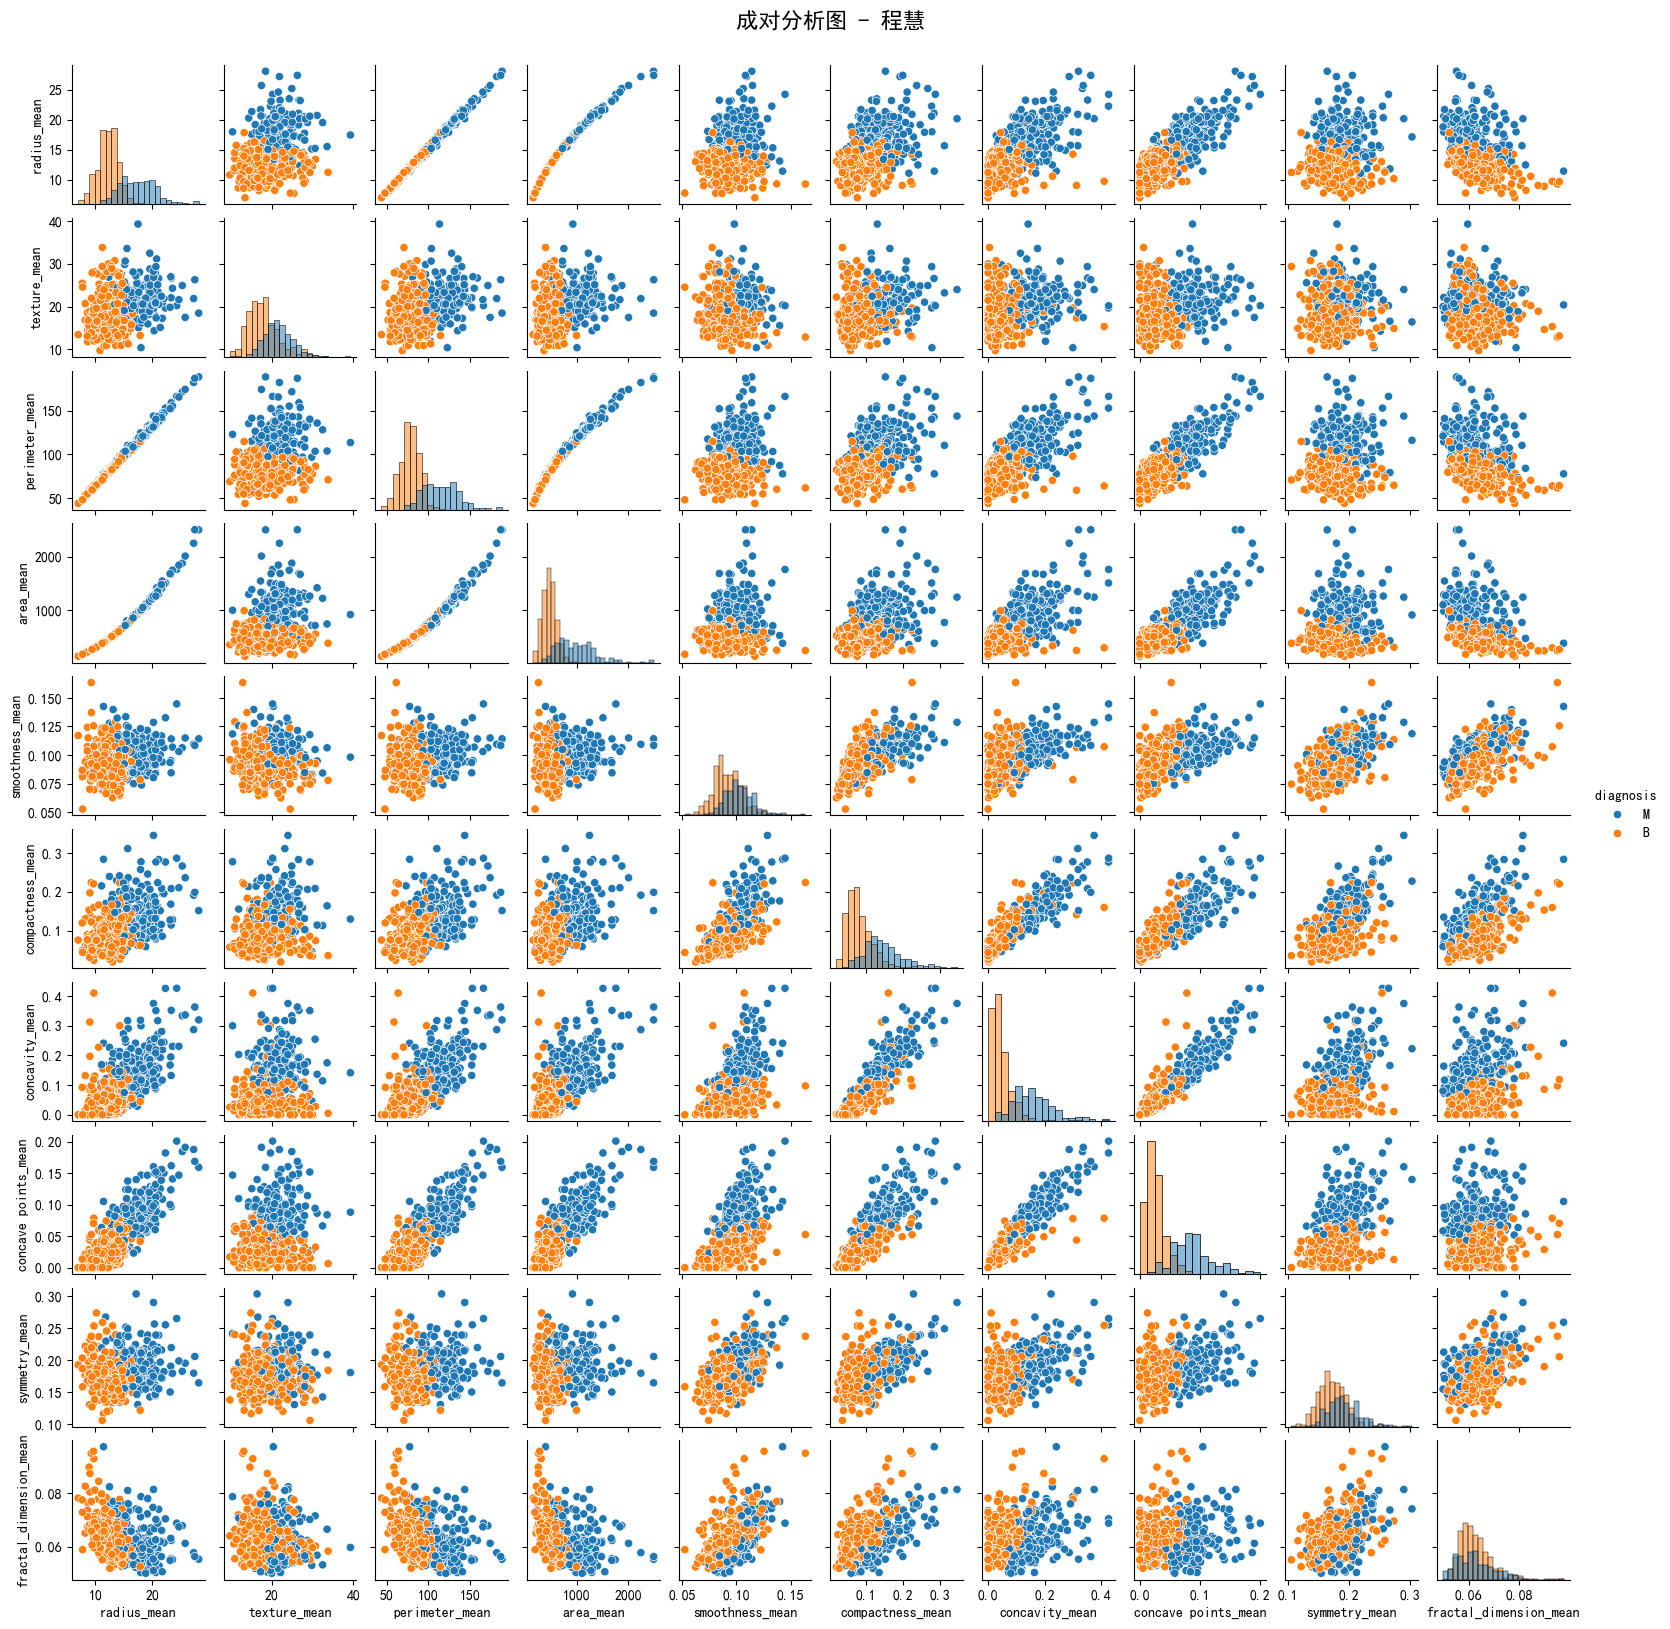

In [43]:
# 绘制成对分析图
sns.pairplot(df.iloc[:, :11], hue='diagnosis', diag_kind='hist', height=1.6)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 
plt.suptitle('成对分析图 - 程慧', y=1.02, fontsize=16, ha='center')

通过成对分析图，我们可以发现**radius_mean**、**perimeter_mean**和**area_mean**高度相关，这对后续特征选择很有帮助。

#### 热力图

**热力图**是一种数据可视化技术，根据需要用热力图显示的矩阵，可以用来显示区域内数据的相对密集程度或分布情况。它通常通过使用色彩映射来表示数据的密度或值大小。

在热力图中，每个数据点或区域都被赋予一个颜色值，该颜色值反映了该位置上的数据密集程度或数值大小。一般而言，较高的数值或密集程度会使用较暖的颜色表示（黄色），而较低的数值或密集程度会使用较冷的颜色表示（蓝色）。其他颜色，如红色和紫色，则表示中间程度的数值或密集程度。

通过热力图，我们可以直观的看出所有特征间的**相关关系**。

In [44]:
corr = df.iloc[:,1:].corr()
fig = go.Figure(data=go.Heatmap(z=np.array(corr),x=corr.columns.tolist(),y=corr.columns.tolist(),xgap = 1,ygap = 1))
fig.update_layout(
    title={'text': "特征相关性热力图 - 程慧", 'x': 0.5, 'xanchor': 'center', 'yanchor': 'top'},
    margin=dict(t=25, r=0, b=200, l=200),
    width=1000,
    height=700
)
fig.show()

接下来，我们可以利用热力图做**特征选择**了

## 3、特征工程

### 3.1、特征缩放

In [45]:
df.diagnosis.unique()

array(['M', 'B'], dtype=object)

#### 独热编码

注意到，标签y——`diagnosis`列中的结果为"M"（恶性） 和 "B"（良性）

将 `diagnosis` 结果转化为独热编码的原因包括以下几点：

1. 算法要求：
    - 许多机器学习算法（如逻辑回归、支持向量机、随机森林等）需要数值输入，不能直接处理字符串或类别数据。
    - 将类别数据转换为数值后，算法可以正常运行。

2. 避免顺序关系：
    - 如果直接将类别数据映射为整数（如 "M" → 1, "B" → 0），可能会引入虚假的顺序关系（即，算法可能认为 1 比 0 更大）。
    - 独热编码通过创建二进制列（ `M` 和 `B` 分别为 1 和 0）避免了这种问题。

3. 提高模型性能：
    - 数值编码可以帮助模型更好地理解数据的类别特性，从而提高分类性能。
4. 可解释性：
    - 独热编码使得每个类别都被单独表示，便于后续分析和可视化。
    - 例如，可以通过查看每个类别的权重来理解模型的决策过程。

In [46]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['diagnosis'] = le.fit_transform(df['diagnosis']) # M:1, B:0
df['diagnosis'].value_counts()

diagnosis
0    357
1    212
Name: count, dtype: int64

#### RobustScaler缩放

首先按照8：2划分训练集与测试集

In [47]:
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:], df['diagnosis'], test_size = 0.2, random_state = random_state)


特征缩放的目标是将数值型变量标准化到一个统一的范围，从而提高模型的性能和训练效率。

**常见的缩放方法**：
Normalizer：通过标准差缩放，将数据缩放到单位标准差范围内。
StandardScaler：通过去除均值并缩放到单位方差范围内。这些方法在数据分布较为均匀时表现良好。

在这里，我采用的是**RobustScaler**缩放方法


这是因为在数据集中，某些特征可能包含极端值（异常值），这些值可能会显著影响均值和方差，从而降低Normalizer和StandardScaler的效果。而RobustScaler通过移除中位数（而非均值）并根据四分位数范围（IQR，Interquartile Range）对数据进行缩放。
这种方法对异常值更加鲁棒，因为中位数和四分位数范围不受极端值的显著影响。

In [48]:
scale = RobustScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

### 3.2、降维

通过相关矩阵和联合分布图可以观察到，某些特征之间高度相关，例如`radius_mean`、`perimeter_mean`和`area_mean`。
这些特征对目标变量的影响几乎相同，因此在模型中同时包含这些特征可能会导致冗余。

**维度灾难（Curse of Dimensionality）**：

在实际问题中，数据集包含过多特征可能会导致“维度灾难”。这意味着：
数据量需求增加，计算复杂度变高。
模型可能更容易过拟合，因为高维空间中数据点变得稀疏，模型难以泛化。

为了解决上述问题，可以通过以下两种方式进行降维：

- **主成分分析（PCA）：通过线性变换将原始特征映射到新的特征空间，保留数据中方差最大的方向**。

- **递归特征消除（RFE）：通过训练模型递归地移除最不重要的特征，最终选择最佳特征子集**。

#### 主成分分析（PCA）

**主成分分析法**是一种线性降维算法，也是一种常用的数据预处理方法。

它的目标是是用**方差**来衡量数据的差异性，并将差异性较大的高维数据投影到低维空间中进行表示，同时尽可能保留数据原始特征。

In [49]:
pca = PCA()
pca.fit(X_train)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

fig = px.line(x=np.arange(1,exp_var_cumul.shape[0]+1), y=exp_var_cumul, markers=True, labels={'x':'主成分数量', 'y':'累计解释方差'})

#fig.add_shape(type='line', line=dict(dash='dash'),x0=0, x1=30, y0=0.95, y1=0.95)#标记可解释方差阈值
fig.update_layout(title={'text': "PCA中累计解释方差与主成分数量关系 - 程慧", 'x': 0.5, 'xanchor': 'center', 'yanchor': 'top'},
                  xaxis_title='主成分数量',
                  yaxis_title='累计解释方差',
                  width=800, height=500)
fig.show()

在PCA的累计解释方差曲线中，**肘部**是指曲线从陡峭变为平缓的转折点。它表示在该点之后，增加更多的主成分对解释总方差的贡献变得较小。

**第四个主成分**出现肘部，意味着前四个主成分已经能够解释大部分的方差，这表明这些主成分已经捕获了数据的主要信息。

#### 递归特征消除与交叉验证（REFCV）

RFE的工作原理是首先训练一个模型，并利用模型的coef_或feature_importances_属性来获取每个特征的重要性。

然后，从当前的特征集合中移除**最不重要的特征**，并在剩余的特征上重新训练模型。这个过程一直重复，直到达到所需的特征数量为止。

这里选择的模型是**决策树**

最优特征数: 4


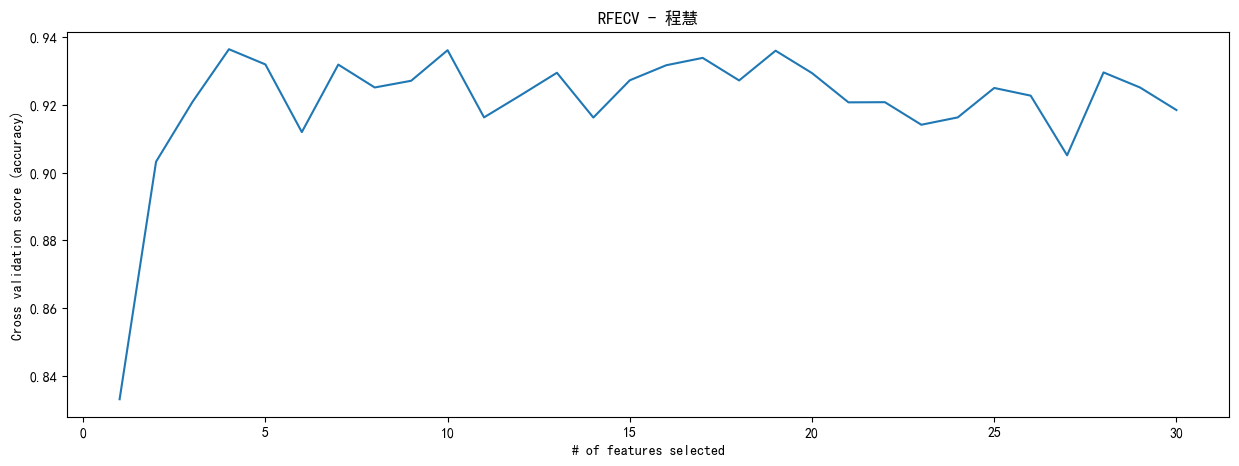

In [50]:
rfecv = RFECV(cv=StratifiedKFold(n_splits=10, random_state=random_state, shuffle=True),
      estimator=DecisionTreeClassifier(), scoring='accuracy')#十折交叉验证
    
rfecv.fit(X_train, y_train)

print("最优特征数: %d" % rfecv.n_features_)#打印最优特征数量

plt.figure(figsize=(15,5))
plt.xlabel("# of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
    rfecv.cv_results_['mean_test_score'],
)
plt.title("RFECV - 程慧")
plt.show()

In [51]:
selected_features = df.columns[1:][rfecv.get_support()]
print("Selected optimal features:", selected_features.tolist())

Selected optimal features: ['concave points_mean', 'texture_worst', 'perimeter_worst', 'concave points_worst']


通过**递归特征消除**，可以减少数据集中可能存在高度相关冗余特征的特征。

经过REF，保留的特征有`concave points_mean`, `radius_worst`, `texture_worst`, `perimeter_worst`, `concave points_worst`，其他特征的移除可以大幅**减小模型训练开销**，并**提升模型泛化性能**。

### 3.3、超参数选择（网格搜索交叉验证）

**网格搜索交叉验证**

**网格搜索**是一种系统化的超参数优化方法，通过在指定的参数空间中穷举所有可能的参数组合，找到使模型性能最优的参数。
它适用于需要调优的超参数较少且参数范围明确的情况。

**交叉验证**是一种评估模型性能的技术，通过将数据分为多个子集（通常称为“折”），在不同的子集上训练和测试模型，以减少过拟合的风险。

在网格搜索中，交叉验证用于评估每组超参数组合的性能，确保选择的参数在未见数据上也能表现良好。

In [52]:
def modelselection(classifier, parameters, scoring, X_train):
    clf = GridSearchCV(estimator=classifier,
                   param_grid=parameters,
                   scoring= scoring,
                   cv=5,
                   n_jobs=-1)
    clf.fit(X_train, y_train)
    cv_results = clf.cv_results_
    best_parameters = clf.best_params_
    best_result = clf.best_score_
    print('The best parameters for classifier is', best_parameters)
    print('The best training score is %.3f:'% best_result)
    return cv_results, best_parameters, best_result

定义**modelselection**函数，用于通过网格搜索交叉验证优化分类器的超参数，并返回最佳参数和相关结果。

**传递参数**

classifier：要优化的分类器对象。

parameters：超参数网格，格式为字典。

scoring：评估指标，例如 'accuracy' 或 'f1'，用于衡量模型性能。

X_train：训练数据，用于拟合模型。

## 4、模型性能指标

#### 主成分分析（PCA）中主成分数量与模型性能（准确率）和训练时间之间的关系

**主成分分析（PCA）中主成分数量与模型性能（准确率）和训练时间的关系**是一个主要用于评估降维对模型性能和效率的指标。

如果主成分数量减少后，模型准确率保持稳定或略有提升，说明降维成功**去除了冗余特征和噪声**。

且主成分数量减少一般会减少模型训练开销，**降低模型训练时间**。

In [68]:
def PCA_curves(PCA_cv_score, PCA_test_score, training_time):
    # PCA_cv_score: 交叉验证分数
    # PCA_test_score: 测试分数
    # training_time: 训练时间
    fig = make_subplots(
    rows=1, cols=2,
    specs=[[{"type": "scatter"}, {"type": "scatter"}]],
    subplot_titles=('# of Components in PCA versus Model Accuracy','# of Components in PCA versus Training Time')
    )
    
    fig.add_trace(go.Scatter(x=n,y=PCA_cv_score,
                             line=dict(color='rgb(231,107,243)', width=2), name='CV score'),
                  row=1, col=1)
    fig.add_trace(go.Scatter(x=n,y=PCA_test_score,
                             line=dict(color='rgb(0,176,246)', width=2), name='Test score'),              
                  row=1, col=1)    
    fig.add_trace(go.Scatter(x=n,y=training_time,
                             line=dict(color='rgb(0,100,80)', width=2), name='Training time'),
                  row=1, col=2)
    fig.update_xaxes(title_text='# of components')
    fig.update_layout(title={'text': "PCA主成分数量与模型准确率/训练时间关系图 - 程慧", 'x': 0.5, 'xanchor': 'center', 'yanchor': 'top'})
    fig.update_yaxes(title_text='Accuracy', row=1, col=1)
    # fig.update_xaxes(title_text="Recall", row=1, col=2)
    fig.update_yaxes(title_text='Training time', row=1, col=2)
    fig.show()

#### 混淆矩阵及其性能指标


**混淆矩阵**：

混淆矩阵是一个表格，用于比较模型的预测结果与实际值之间的匹配情况。
它将预测结果分为四种类型：

True Positive (TP)：恶性肿瘤被正确分类为恶性。

True Negative (TN)：良性肿瘤被正确分类为良性。

False Positive (FP)：良性肿瘤被错误分类为恶性（假阳性）。

False Negative (FN)：恶性肿瘤被错误分类为良性（假阴性）。

**性能指标（Metrics）**：

基于混淆矩阵，可以计算多个关键指标来评估模型性能：

Accuracy（准确率）：表示模型预测正确的比例，公式为 (TP + TN) / (TP + TN + FP + FN)。它是整体性能的一个简单衡量标准。

Sensitivity（灵敏度/召回率）：也称为真正率，表示模型正确识别出正类（恶性肿瘤）的能力，公式为 TP / (TP + FN)。

Specificity（特异性）：也称为真负率，表示模型正确识别出负类（良性肿瘤）的能力，公式为 TN / (TN + FP)。

Precision（精确率）：表示模型预测为正类的样本中实际为正类的比例，公式为 TP / (TP + FP)。

Recall（召回率）：与灵敏度相同，表示模型对正类的覆盖能力。

F-measure（F1分数）：精确率和召回率的调和平均值，公式为 2 * Precision * Recall / (Precision + Recall)，用于平衡精确率和召回率之间的权衡。

In [54]:
def metrics(X,CV_clf):
    # X: test data
    # CV_clf: trained classifier
    y_pred = CV_clf.predict(X)
    cm = confusion_matrix(y_test, y_pred)
    tn = cm[0,0]
    fp = cm[0,1]
    fn = cm[1,0]
    tp = cm[1,1]
    Accuracy=(tp+tn)/(tp+tn+fp+fn)
    Sensitivity=tp/(tp+fn)
    Specificity=tn/(tn+fp)
    Precision=tp/(tp+fp)
    F_measure=2*tp/(2*tp+fp+fn)
    print('Accuracy=%.3f'%Accuracy)
    print('Sensitivity=%.3f'%Sensitivity) # as the same as recall
    print('Specificity=%.3f'%Specificity)
    print('Precision=%.3f'%Precision)
    print('F-measure=%.3f'%F_measure)
    return Accuracy, Sensitivity, Specificity, Precision, F_measure
 #   plot_confusion_matrix(CV_clf, X_test, y_test)

#### ROC曲线(AUC)

**ROC曲线**是一种可视化工具，用于总结分类模型在不同概率阈值下的性能。
它通过绘制真正率（True Positive Rate, TPR）（即灵敏度或召回率）与假正率（False Positive Rate, FPR）（即1 - 特异性）的关系，展示模型在不同阈值下的权衡。通过调整概率阈值，可以观察模型在不同权衡下的表现，例如更高的灵敏度或更低的假正率。

无预测价值的分类器：ROC曲线接近对角线（从左下角到右上角），表示模型的预测与随机猜测相当。

完美分类器：ROC曲线经过左上角点（100%的真正率和0%的假正率），表示模型能够完全正确地分类所有样本。

**AUC（曲线下面积）**：
AUC是ROC曲线下方面积的度量，数值范围为0.5到1.0。
AUC = 0.5：表示分类器没有预测能力，与随机猜测相同。
AUC = 1.0：表示分类器具有完美的预测能力。
AUC越接近1.0，模型的整体性能越好。

In [55]:
def plot_roc_curve(y_test, y_score):
    # y_test: 测试集的真实标签
    # y_score: 模型预测的概率分数
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)  # 计算AUC值

    # 绘制ROC曲线
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

#### 精确率-召回率曲线

**精确率**表示模型预测为正类的样本中实际为正类的比例，公式为 TP / (TP + FP)。

**召回率**也称为真正率（True Positive Rate, TPR），表示模型正确识别出正类的能力，公式为 TP / (TP + FN)


无预测能力的分类器：曲线接近水平线（y=0.5），表示模型的预测与随机猜测相当。

完美分类器：曲线向(1,1)方向弯曲，表示模型能够在高精确率和高召回率之间取得良好平衡。

In [56]:
def plot_roc_prc(y_test, y_score):
    # 计算 ROC 曲线和 AUC
    fpr, tpr, roc_thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    precision, recall, prc_thresholds = precision_recall_curve(y_test, y_score)
    prc_auc = auc(recall, precision)
    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{"type": "scatter"}, {"type": "scatter"}]],
        subplot_titles=(f'ROC Curve (AUC={roc_auc:.4f})', f'Precision-Recall Curve (AUC={prc_auc:.4f})')
    )

    # 绘制 ROC 曲线
    fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name='ROC Curve'), row=1, col=1)
    fig.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1, row=1, col=1)

    # 绘制 Precision-Recall 曲线
    fig.add_trace(go.Scatter(x=recall, y=precision, mode='lines', name='Precision-Recall Curve'), row=1, col=2)
    fig.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0.5, y1=0.5, row=1, col=2)

    fig.update_xaxes(title_text="False Positive Rate / 1-Specificity", row=1, col=1)
    fig.update_yaxes(title_text="True Positive Rate / Recall", row=1, col=1)
    fig.update_xaxes(title_text="Recall", row=1, col=2)
    fig.update_yaxes(title_text="Precision", row=1, col=2)

    fig.show()
    return roc_thresholds, prc_thresholds

## 5、模型训练

### 5.1、梯度提升树与主成分分析法（PCA）

#### 梯度提升树

**GBDT（Gradient Boosting Decision Tree）**，全名叫**梯度提升决策树**，是一种迭代的决策树算法，它通过构造一组弱的学习器（树），并把多颗决策树的结果累加起来作为最终的预测输出。该算法将决策树与集成思想进行了有效的结合。

GBDT的原理很简单：

- 所有弱分类器的结果相加等于预测值。
- 每次都以当前预测为基准，下一个弱分类器去拟合残差（预测值与真实值之间的误差）。
- GBDT的弱分类器使用的是树模型。

In [57]:
from sklearn.ensemble import GradientBoostingClassifier

classifier_gb = GradientBoostingClassifier(random_state=random_state)
parameters_gb = {#定义超参数搜索范围
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}
scoring_gb = 'accuracy'

训练一个普通的梯度提升分类器，并通过测试数据评估其性能。

In [58]:
gb_clf = GradientBoostingClassifier(n_estimators=100,
                                     learning_rate=0.1,
                                     max_depth=3,
                                     random_state=random_state)
gb_clf.fit(X_train, y_train)

# Metrics
gb_metrics = metrics(X_test, gb_clf)

Accuracy=0.956
Sensitivity=0.930
Specificity=0.972
Precision=0.952
F-measure=0.941


#### 梯度提升树 + PCA

接下来，引入PCA降维方法。

函数 compare_pca_gb，用于比较在不同主成分数量下，得到的模型性能。

它通过循环调整 PCA 的主成分数量，评估模型的交叉验证分数、测试分数以及训练时间。

In [59]:
def compare_pca_gb(n_components):
    cv_score, test_score, cv_training_time = [], [], []
    for n in n_components:
        print("The number of components in PCA is:%d " % n)
        
        pca = PCA(n_components=n, svd_solver="full", random_state=random_state)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        
        # Model Selection
        cv_results, best_param, best_result = modelselection(classifier_gb, parameters_gb, scoring_gb, X_train_pca)
        training_time = np.mean(np.array(cv_results['mean_fit_time']) + np.array(cv_results['mean_score_time']))
        cv_score.append(best_result)
        cv_training_time.append(training_time)
        
        # Train the model with the best parameters
        CV_clf = GradientBoostingClassifier(n_estimators=best_param['n_estimators'],
                                             learning_rate=best_param['learning_rate'],
                                             max_depth=best_param['max_depth'],
                                             random_state=random_state)
        CV_clf.fit(X_train_pca, y_train)
        score = CV_clf.score(X_test_pca, y_test)
        test_score.append(score)
    
    return cv_score, test_score, cv_training_time

In [60]:
n_features = X_train.shape[1]
n = np.arange(2, n_features+2, 2) 

PCA_cv_score, PCA_test_score, PCA_cv_training_time= compare_pca_gb(n_components = n)

The number of components in PCA is:2 
The best parameters for classifier is {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 150}
The best training score is 0.912:
The number of components in PCA is:4 
The best parameters for classifier is {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
The best training score is 0.941:
The number of components in PCA is:6 
The best parameters for classifier is {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
The best training score is 0.965:
The number of components in PCA is:8 
The best parameters for classifier is {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50}
The best training score is 0.963:
The number of components in PCA is:10 
The best parameters for classifier is {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
The best training score is 0.958:
The number of components in PCA is:12 
The best parameters for classifier is {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
The best tra

In [61]:
# 打印最好的准确率及相应的特征数量
print('The best accuracy of is: %.3f' % max(PCA_test_score) + ', where the total number of features selected is %d' % rfecv.n_features_)

# 获取最佳准确率的索引
best_index = np.argmax(PCA_test_score)

best_model = GradientBoostingClassifier(n_estimators=parameters_gb['n_estimators'][best_index // 9],
										learning_rate=parameters_gb['learning_rate'][(best_index % 9) // 3],
										max_depth=parameters_gb['max_depth'][best_index % 3],
										random_state=random_state)
best_model.fit(X_train, y_train)

# 打印性能指标
print(metrics(X_test, best_model))

The best accuracy of is: 0.956, where the total number of features selected is 4
Accuracy=0.965
Sensitivity=0.930
Specificity=0.986
Precision=0.976
F-measure=0.952
(np.float64(0.9649122807017544), np.float64(0.9302325581395349), np.float64(0.9859154929577465), np.float64(0.975609756097561), np.float64(0.9523809523809523))


让我们可视化**梯度提升树中PCA主成分数量与模型准确率/训练时间的关系**的折线图

In [69]:
PCA_curves(PCA_cv_score,PCA_test_score,PCA_cv_training_time)

还记得我们之前的**普通梯度提升树结果**吗？95.6%

对比运用了PCA主成分分析法的梯度提升树，在**PCA主成分为4**时，**准确率保持稳定**，但**训练时间大大减小**！

在降维后的数据上进行模型训练、超参数优化和性能评估。

In [74]:
pca = PCA(n_components=(i+1)*2, svd_solver="full", random_state=random_state)
X_PCA_train = pca.fit_transform(X_train)
X_PCA_test = pca.transform(X_test)
# Model Selection
cv_results, best_param, best_result = modelselection(classifier_gb, parameters_gb, scoring_gb, X_PCA_train)

# Classifier with the best hyperparameters
gb_PCA = GradientBoostingClassifier(n_estimators=best_param['n_estimators'],
                                    learning_rate=best_param['learning_rate'],
                                    max_depth=best_param['max_depth'],
                                    random_state=random_state)
gb_PCA.fit(X_PCA_train, y_train)

# Metrics
gb_PCA_metrics = metrics(X_PCA_test, gb_PCA)


The best parameters for classifier is {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100}
The best training score is 0.945:
Accuracy=0.947
Sensitivity=0.953
Specificity=0.944
Precision=0.911
F-measure=0.932


#### 改变阈值对性能指标的影响

threshold = 0.1 : Accuracy=0.947 Sensitivity=0.953 Specificity=0.944 Precision=0.911
threshold = 0.2 : Accuracy=0.947 Sensitivity=0.953 Specificity=0.944 Precision=0.911
threshold = 0.3 : Accuracy=0.947 Sensitivity=0.953 Specificity=0.944 Precision=0.911
threshold = 0.4 : Accuracy=0.947 Sensitivity=0.953 Specificity=0.944 Precision=0.911
threshold = 0.5 : Accuracy=0.947 Sensitivity=0.953 Specificity=0.944 Precision=0.911
threshold = 0.6 : Accuracy=0.947 Sensitivity=0.953 Specificity=0.944 Precision=0.911
threshold = 0.7 : Accuracy=0.947 Sensitivity=0.930 Specificity=0.958 Precision=0.930
threshold = 0.8 : Accuracy=0.947 Sensitivity=0.930 Specificity=0.958 Precision=0.930
threshold = 0.9 : Accuracy=0.947 Sensitivity=0.930 Specificity=0.958 Precision=0.930


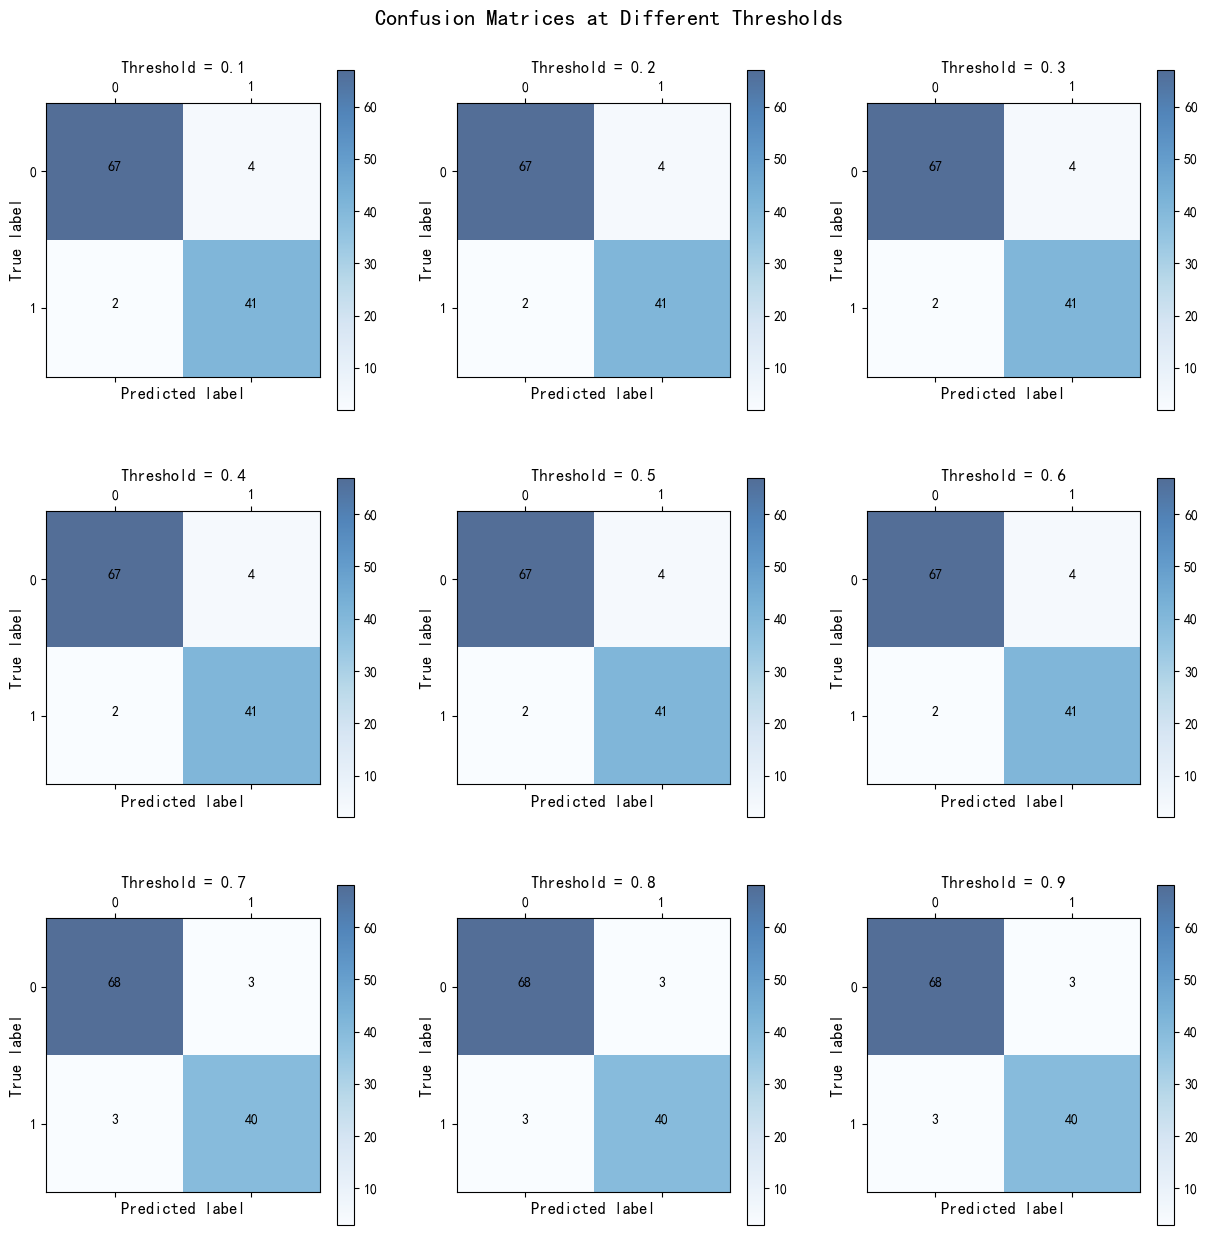

In [ ]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

for n, ax in zip(thresholds, axs.ravel()):
    y_score = gb_PCA.predict_proba(X_PCA_test)[:, 1] > n
    
    cm = confusion_matrix(y_test, y_score)
    
    tp = cm[1, 1]
    fn = cm[1, 0]
    fp = cm[0, 1]
    tn = cm[0, 0]

    print('threshold = %s :' % n,
          'Accuracy={:.3f}'.format((tp + tn) / (tp + tn + fp + fn)),
          'Sensitivity={:.3f}'.format(tp / (tp + fn)),
          'Specificity={:.3f}'.format(tn / (tn + fp)),
          'Precision={:.3f}'.format(tp / (tp + fp)))
    
    im = ax.matshow(cm, cmap='Blues', alpha=0.7)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j], horizontalalignment='center')
        
    ax.set_ylabel('True label', fontsize=12)
    ax.set_xlabel('Predicted label', fontsize=12)
    ax.set_title('Threshold = %s' % n, fontsize=12)
    fig.colorbar(im, ax=ax, orientation='vertical')
    
    fig.suptitle('不同阈值下的模型性能指标 - 程慧', fontsize=16, y=0.92)
plt.show()

图上打印的四个指标分别是：

1. **Accuracy（准确率）**:  表示模型预测正确的比例。  

1. **Sensitivity（灵敏度/召回率）**:  表示模型正确识别出正类（恶性肿瘤）的能力。

1. **Specificity（特异性）**:  
    表示模型正确识别出负类（良性肿瘤）的能力。

2. **Precision（精确率）**:  
    表示模型预测为正类的样本中实际为正类的比例。

当**阈值为0.5**时，我们关注的四个指标均达到最大

因此，合理的阈值选择是0.5

### 5.2、随机森林与主成分分析法（PCA）

#### 随机森林

**随机森林**就是通过集成学习的思想将多棵树集成的一种算法，它的基本单元是决策树，而它的本质属于机器学习的一大分支——集成学习方法。

随机森林的名称中有两个关键词，一个是**随机**，一个就是**森林**。“森林”我们很好理解，一棵叫做树，那么成百上千棵就可以叫做森林了，这样的比喻还是很贴切的，其实这也是随机森林的主要思想–集成思想的体现。

从直观角度来解释，每棵决策树都是一个分类器，那么对于一个输入样本，N棵树会有N个分类结果。而随机森林集成了所有的分类投票结果，将投票次数最多的类别指定为最终的输出，这就是一种最简单的 Bagging 思想。

**与梯度提升树的不同之处：**

与梯度提升树不同的是，**随机森林**基于**Bagging**思想，通过对数据集进行随机采样（有放回）生成多个子数据集，训练多棵独立的决策树，最终通过 投票（分类任务）或 平均（回归任务）来得到预测结果，每棵树的训练是独立的，训练过程可以并行化。

而**梯度提升树**基于 Boosting 思想，通过逐步构建决策树，每棵树都试图修正前一棵树的预测误差。每棵树的训练依赖于前一棵树的结果，训练过程是串行的。

让我们创建一个随机森林分类器，并通过网格搜索交叉验证优化一超参数，并在测试数据上评估其性能

In [ ]:
parameters_rf = {
    'n_estimators': [20, 50, 100, 150, 200],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False],
}

scoring_rf = 'accuracy' 
classifier_rf = RandomForestClassifier(random_state=random_state)

#超参数搜索
cv_results, best_param, best_result = modelselection(classifier_rf,parameters_rf, scoring_rf, X_train)

# Classifier with the best hyperparameters
rf_clf = RandomForestClassifier(n_estimators = best_param['n_estimators'],
                                criterion = best_param['criterion'],
                                bootstrap = best_param['bootstrap'],
                                random_state=random_state)
rf_clf.fit(X_train, y_train)

rf_metrics = metrics(X_test,rf_clf)

The best parameters for classifier is {'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 100}
The best training score is 0.967:
Accuracy=0.965
Sensitivity=0.930
Specificity=0.986
Precision=0.976
F-measure=0.952


可以看见，利用30个特征训练得到的随机森林正确率在96.5%

#### 随机森林 + PCA

我们进一步加上PCA降维，测试不同主成分数量与模型准确率和模型训练时间的关系

In [ ]:
def compare_pca(n_components):
    cv_score, test_score, cv_training_time = [], [], []
    for n in n_components:
        print("The number of components in PCA is:%d "% n)
        pca = PCA(n_components=n, svd_solver="full",random_state=random_state)
        X_PCA_train = pca.fit_transform(X_train)
        X_PCA_test = pca.transform(X_test)
        # Model Selection
        cv_results, best_param, best_result = modelselection(classifier_rf, parameters_rf, scoring_rf, X_PCA_train)
        training_time = np.mean(np.array(cv_results['mean_fit_time'])+np.array(cv_results['mean_score_time']))
        cv_score.append(best_result)
        cv_training_time.append(training_time)
        CV_clf = RandomForestClassifier(n_estimators = best_param['n_estimators'],
                                        criterion = best_param['criterion'],
                                        bootstrap = best_param['bootstrap'],
                                        random_state=random_state)
        CV_clf.fit(X_PCA_train, y_train)
        score = CV_clf.score(X_PCA_test, y_test)
        test_score.append(score)
    print(cv_score, test_score, cv_training_time)
    return cv_score, test_score, cv_training_time

In [ ]:
n_features = X_train.shape[1]
n = np.arange(2, n_features+2, 2) 
PCA_cv_score, PCA_test_score, PCA_cv_training_time = compare_pca(n_components=n)

The number of components in PCA is:2 
The best parameters for classifier is {'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 150}
The best training score is 0.919:
The number of components in PCA is:4 
The best parameters for classifier is {'bootstrap': True, 'criterion': 'gini', 'n_estimators': 50}
The best training score is 0.941:
The number of components in PCA is:6 
The best parameters for classifier is {'bootstrap': False, 'criterion': 'gini', 'n_estimators': 200}
The best training score is 0.967:
The number of components in PCA is:8 
The best parameters for classifier is {'bootstrap': False, 'criterion': 'gini', 'n_estimators': 150}
The best training score is 0.969:
The number of components in PCA is:10 
The best parameters for classifier is {'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 200}
The best training score is 0.965:
The number of components in PCA is:12 
The best parameters for classifier is {'bootstrap': False, 'criterion': 'entropy', 'n_estimat

In [ ]:
# 打印最好的准确率及相应的特征数量
print(f"The best accuracy is: {max(PCA_test_score):.3f}, where the total number of features selected is {rfecv.n_features_}")

best_index = np.argmax(PCA_test_score)
best_model = RandomForestClassifier(n_estimators=parameters_rf['n_estimators'][best_index // 6],
                                     criterion=parameters_rf['criterion'][(best_index % 6) // 3],
                                     bootstrap=parameters_rf['bootstrap'][best_index % 3],
                                     random_state=random_state)
best_model.fit(X_train, y_train)
# 打印性能指标
print(metrics(X_test, best_model))


The best accuracy is: 0.974, where the total number of features selected is 4
Accuracy=0.965
Sensitivity=0.930
Specificity=0.986
Precision=0.976
F-measure=0.952
(np.float64(0.9649122807017544), np.float64(0.9302325581395349), np.float64(0.9859154929577465), np.float64(0.975609756097561), np.float64(0.9523809523809523))


输出得到，模型在选择4个特征时，准确率最大。

让我们绘制PCA主成分数量与模型准确率/训练时间的关系的图表，直观感受PCA对随机森林训练的影响。

In [73]:
PCA_curves(PCA_cv_score, PCA_test_score, PCA_cv_training_time)

在选择到4个主成分时，测试准确率达到了**97.4%**。

对比普通的随机森林，**PCA + 随机森林**消除了数据冗余噪声，同时实现降维，使模型准确率提升的同时**训练时间大大减少**

### 5.3、梯度提升树与递归特征消除（REF）

接下来，尝试**RFE + 梯度提升分类器**，测试模型表现

In [ ]:
X_train_selected = X_train[:, rfecv.get_support()]
X_test_selected = X_test[:, rfecv.get_support()]

cv_results, best_param, best_result = modelselection(classifier_gb, parameters_gb, scoring_gb, X_train_selected)

# Classifier with the best hyperparameters
gb_RFE = GradientBoostingClassifier(n_estimators=best_param['n_estimators'],
                                    learning_rate=best_param['learning_rate'],
                                    max_depth=best_param['max_depth'],
                                    random_state=random_state)
gb_RFE.fit(X_train_selected, y_train)

# Metrics
gb_RFE_metrics = metrics(X_test_selected, gb_RFE)


The best parameters for classifier is {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
The best training score is 0.967:
Accuracy=0.956
Sensitivity=0.930
Specificity=0.972
Precision=0.952
F-measure=0.941


相较于未进行特征选择的梯度提升数，正确率为95.6%，经过RFE特征选择后的模型在准确率提升到了97.2%，**正确率有了明显上升**。

同时，REF选择的特征数量与PCA主成分数量**相同**，都为4个，**大大减少了训练开销**。

### 5.4、随机森林与递归特征消除（RFE）

In [ ]:
X_train_selected = X_train[:,rfecv.get_support()]
X_test_selected = X_test[:,rfecv.get_support()]

cv_results, best_param, best_result = modelselection(classifier_rf,parameters_rf, scoring_rf, X_train_selected)

# Classifier with the best hyperparameters
rf_RFE = RandomForestClassifier(n_estimators = best_param['n_estimators'],
                                criterion = best_param['criterion'],
                                bootstrap = best_param['bootstrap'],
                                random_state=random_state)
rf_RFE.fit(X_train_selected, y_train)

# Metrics
rf_RFE_metrics = metrics(X_test_selected ,rf_RFE)

The best parameters for classifier is {'bootstrap': True, 'criterion': 'gini', 'n_estimators': 100}
The best training score is 0.967:
Accuracy=0.956
Sensitivity=0.930
Specificity=0.972
Precision=0.952
F-measure=0.941


相较于未进行特征选择的随机森林正确率为95.6%，经过RFE特征选择后的模型**准确率保持稳定**。

同时，REF选择的特征数量与PCA主成分数量**相同**，都为4个，**大大减少了训练开销**。

## 6、模型综合比较与建议

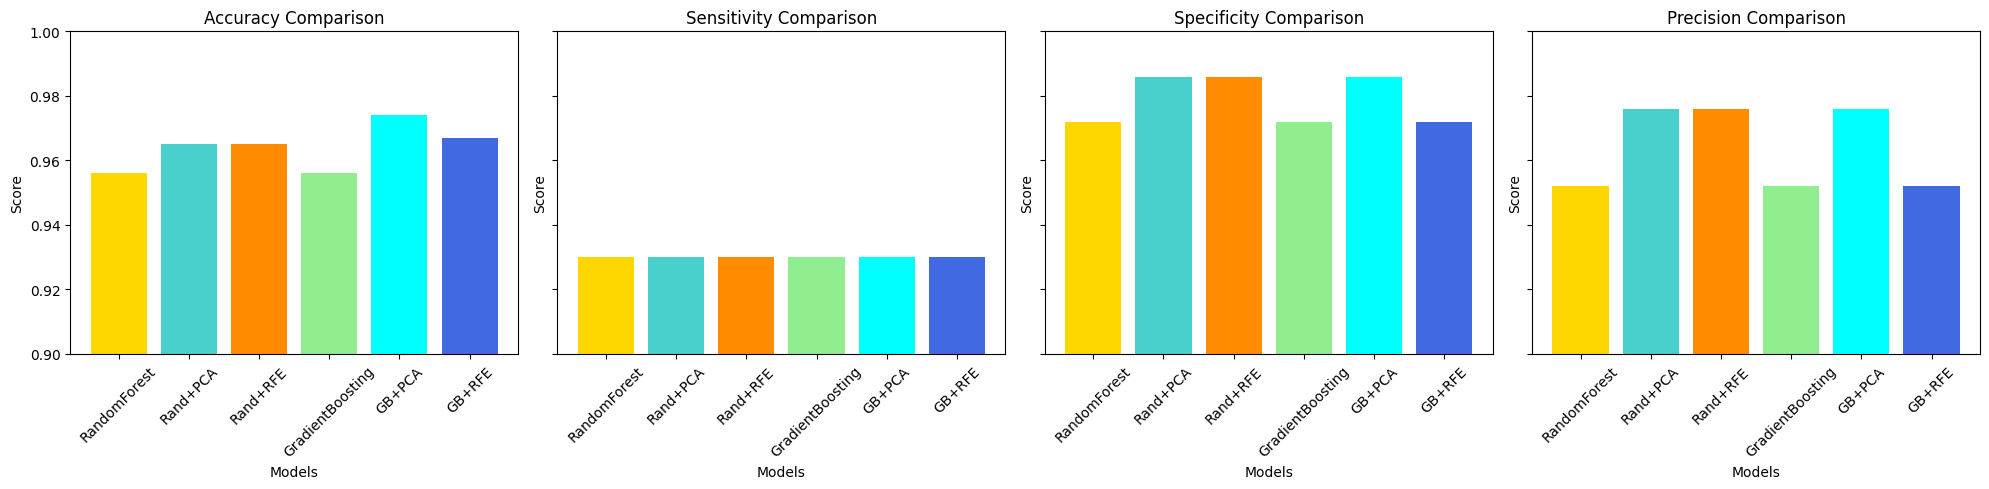

In [ ]:
# 模型名称
models = ['RandomForest', 'Rand+PCA', 'Rand+RFE', 'GradientBoosting', 'GB+PCA', 'GB+RFE']

# 模型性能指标
metrics_to_plot = ['Accuracy', 'Sensitivity', 'Specificity', 'Precision']
colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen', 'cyan', 'royalblue']

# 定义 df_scores 数据框
df_scores = pd.DataFrame({
    'GradientBoosting': [0.956, 0.930, 0.972, 0.952],
    'GB+PCA': [0.965, 0.930, 0.986, 0.976],
    'GB+RFE': [0.965, 0.930, 0.986, 0.976],
    'RandomForest': [0.956, 0.930, 0.972, 0.952],
    'Rand+PCA': [0.974, 0.930, 0.986, 0.976],
    'Rand+RFE': [0.967, 0.930, 0.972, 0.952]
}, index=['Accuracy', 'Sensitivity', 'Specificity', 'Precision'])

# 提取数据
data = df_scores.loc[metrics_to_plot].T

# 创建子图
fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(20, 5), sharey=True)

# 绘制每个性能指标的柱状图
for ax, metric in zip(axes, metrics_to_plot):
    ax.bar(models, data[metric], color=colors)
    ax.set_title(f'{metric} Comparison')
    ax.set_xlabel('Models')
    ax.set_ylabel('Score')
    ax.set_ylim(0.9, 1.0)  # 设置y轴范围
    ax.tick_params(axis='x', rotation=45)

# 调整布局
plt.tight_layout()
plt.show()

**结论**

不论对于随机森林还是梯度提升树，PCA和REF对**准确率均有提升**

相较来说，**PCA**对准确率的提升大于REF

而对于我们更关心的**sensitivity指标**，降维前后数据**保持稳定**。

对于**specificity和precision**，降维后数据**均有提升**。

REF和PCA在这个训练中选择的**特征值都为4**，相较于原始的30个特征，训练开销大大下降


**我的看法**

**降维的有效性**取决于后续使用的分类算法以及输入数据的特性。不同的算法对降维的敏感性不同。例如，线性模型（如逻辑回归）通常对降维后的数据表现更好，而复杂模型（如随机森林）可能对降维的依赖较小。

**REF有效性不如PCA的原因**可能是：RFE 是一种有监督的特征选择方法，依赖于模型的特征重要性（这里使用决策树）。它逐步移除对目标变量贡献较小的特征。而随机森林和梯度提升树本身具有内置的特征选择能力，能够自动忽略不重要的特征，因此REF降维对其性能的影响较小。

虽然降维对某些模型的分类性能没有显著提升，但随着特征数量的减少，**训练时间显著降低**。